In [337]:
# import all the required libraries
from pathlib import Path
from pandas.plotting import parallel_coordinates
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge, LogisticRegression
import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from math import sqrt
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SaiKrishna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [373]:
# read the excel and print top 5 values
airbnb_df = pd.read_excel("airbnb.xlsx", index_col=False)
airbnb_df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaT,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaT,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaT,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,2008-06-26,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,2008-06-26,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [374]:
# shape of the dataframe
airbnb_df.shape

(30478, 13)

In [375]:
# info such as datatypes of each variable
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Host Id                     30478 non-null  int64         
 1   Host Since                  30475 non-null  datetime64[ns]
 2   Name                        30478 non-null  object        
 3   Neighbourhood               30478 non-null  object        
 4   Property Type               30475 non-null  object        
 5   Review Scores Rating (bin)  22155 non-null  float64       
 6   Room Type                   30478 non-null  object        
 7   Zipcode                     30344 non-null  float64       
 8   Beds                        30393 non-null  float64       
 9   Number of Records           30478 non-null  int64         
 10  Number Of Reviews           30478 non-null  int64         
 11  Price                       30478 non-null  int64     

In [376]:
# fetch zip code using regex and trim spaces and removing special characters
airbnb_df['Zipcode'] = airbnb_df['Zipcode'].astype(str)
airbnb_df['Zipcode'] = airbnb_df['Zipcode'].str.extract(r'(\d+)')
airbnb_df = airbnb_df.rename(columns={'Neighbourhood ': 'Neighbourhood'})
airbnb_df.shape

(30478, 13)

In [377]:
# dataframe statistics
airbnb_df.describe()

,Host Id,Review Scores Rating (bin),Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
count,3.047800e+04,22155.000000,30393.000000,30478.0,30478.000000,30478.000000,22155.000000
mean,1.273171e+07,90.738659,1.530089,1.0,12.018735,163.589737,91.993230
std,1.190270e+07,9.059519,1.015359,0.0,21.980703,197.785454,8.850373
min,5.000000e+02,20.000000,0.000000,1.0,0.000000,10.000000,20.000000
25%,2.701298e+06,85.000000,1.000000,1.0,0.000000,80.000000,89.000000
50%,8.551693e+06,90.000000,1.000000,1.0,3.000000,125.000000,94.000000
75%,2.120617e+07,100.000000,2.000000,1.0,13.000000,195.000000,100.000000
max,4.303307e+07,100.000000,16.000000,1.0,257.000000,10000.000000,100.000000


In [378]:
# check if any column/s have null values.
for column in airbnb_df.columns:
    num_nulls = airbnb_df[column].isnull().sum()
    if num_nulls > 0:
        print(f"Column '{column}' has {num_nulls} NULL values")
    else:
        print(f"Column '{column}' has no NULL values")

Column 'Host Id' has no NULL values
Column 'Host Since' has 3 NULL values
Column 'Name' has no NULL values
Column 'Neighbourhood' has no NULL values
Column 'Property Type' has 3 NULL values
Column 'Review Scores Rating (bin)' has 8323 NULL values
Column 'Room Type' has no NULL values
Column 'Zipcode' has 134 NULL values
Column 'Beds' has 85 NULL values
Column 'Number of Records' has no NULL values
Column 'Number Of Reviews' has no NULL values
Column 'Price' has no NULL values
Column 'Review Scores Rating' has 8323 NULL values


In [379]:
# drop unwanted columns
print(airbnb_df['Room Type'].unique())
airbnb_df = airbnb_df.drop(columns=['Number of Records'])

['Entire home/apt' 'Private room' 'Shared room']


In [380]:
#drop null rows
df_cleaned = airbnb_df.dropna()
df_cleaned.shape

(22010, 12)

In [381]:
# delete duplicate values
df_cleaned = df_cleaned.drop_duplicates()
# Convert 'Host Since' column to datetime
df_cleaned['Host Since'] = pd.to_datetime(df_cleaned['Host Since'])
df_cleaned.shape

(22007, 12)

In [382]:
# check again if the dataframe has null values
for column in df_cleaned.columns:
    num_nulls = df_cleaned[column].isnull().sum()
    if num_nulls > 0:
        print(f"Column '{column}' has {num_nulls} NULL values")
    else:
        print(f"Column '{column}' has no NULL values")

Column 'Host Id' has no NULL values
Column 'Host Since' has no NULL values
Column 'Name' has no NULL values
Column 'Neighbourhood' has no NULL values
Column 'Property Type' has no NULL values
Column 'Review Scores Rating (bin)' has no NULL values
Column 'Room Type' has no NULL values
Column 'Zipcode' has no NULL values
Column 'Beds' has no NULL values
Column 'Number Of Reviews' has no NULL values
Column 'Price' has no NULL values
Column 'Review Scores Rating' has no NULL values


In [383]:
# fetch the top 1000 records and assign to another dataframe
df_cleaned1 = df_cleaned.head(1000)
df_cleaned1

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number Of Reviews,Price,Review Scores Rating
4,500,2008-06-26,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036,3.0,39,549,96.0
5,1039,2008-07-25,Big Greenpoint 1BD w/ Skyline View,Brooklyn,Apartment,100.0,Entire home/apt,11222,1.0,4,149,100.0
6,1783,2008-08-12,Amazing Also,Manhattan,Apartment,100.0,Entire home/apt,10004,1.0,9,250,100.0
7,2078,2008-08-15,"Colorful, quiet, & near the subway!",Brooklyn,Apartment,90.0,Private room,11201,1.0,80,90,94.0
8,2339,2008-08-20,East Village Cocoon: 2 Bedroom Flat,Manhattan,Apartment,90.0,Entire home/apt,10009,2.0,95,270,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1139,191324,2010-08-04,Blue 2BR above LES art gallery,Manhattan,Apartment,95.0,Entire home/apt,10002,2.0,16,250,99.0
1140,191173,2010-08-04,Chelsea 4BR Loft A+ Location!,Manhattan,Apartment,90.0,Entire home/apt,10011,4.0,17,399,91.0
1141,190789,2010-08-04,"Bright, Modern & Cozy Soho Apt",Manhattan,Apartment,100.0,Entire home/apt,10012,1.0,7,200,100.0
1142,191173,2010-08-04,AMAZING Location 3 BR in Soho,Manhattan,Apartment,80.0,Entire home/apt,10013,3.0,59,289,83.0


In [355]:
# relation b/w Neighbourhood and Price
highest_price_by_neighbourhood = df_cleaned1.groupby('Neighbourhood')['Price'].max()

# This will print the highest price in each neighbourhood
print("Average Price", highest_price_by_neighbourhood)

Average Price Neighbourhood
Bronx             170
Brooklyn          600
Manhattan        1990
Queens            205
Staten Island      70
Name: Price, dtype: int64


The neighbourhood with the highest number of listings is Manhattan with 489 listings.


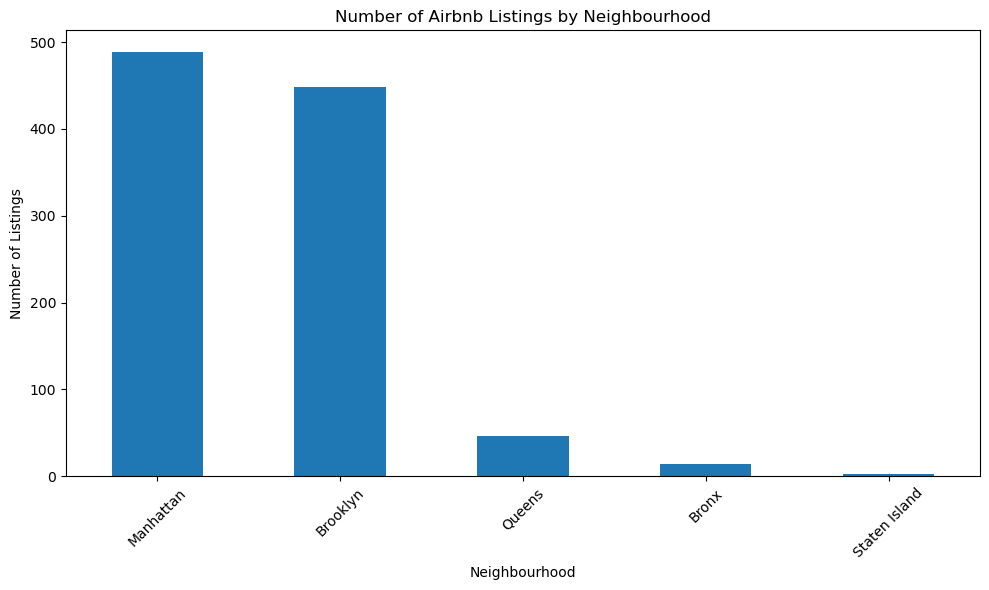

In [356]:
# Print the neighborhood with the highest number of listings
neighbourhood_counts = df_cleaned1['Neighbourhood'].value_counts()
most_listings_neighbourhood = neighbourhood_counts.idxmax()
number_of_listings = neighbourhood_counts.max()
print(f"The neighbourhood with the highest number of listings is {most_listings_neighbourhood} with {number_of_listings} listings.")

# Visualization: A simple bar plot to display the number of listings in each neighborhood
plt.figure(figsize=(10, 6))
neighbourhood_counts.plot(kind='bar')
plt.title('Number of Airbnb Listings by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()  # May need to adjust or use plt.show() depending on your environment

# Show the plot
plt.show()


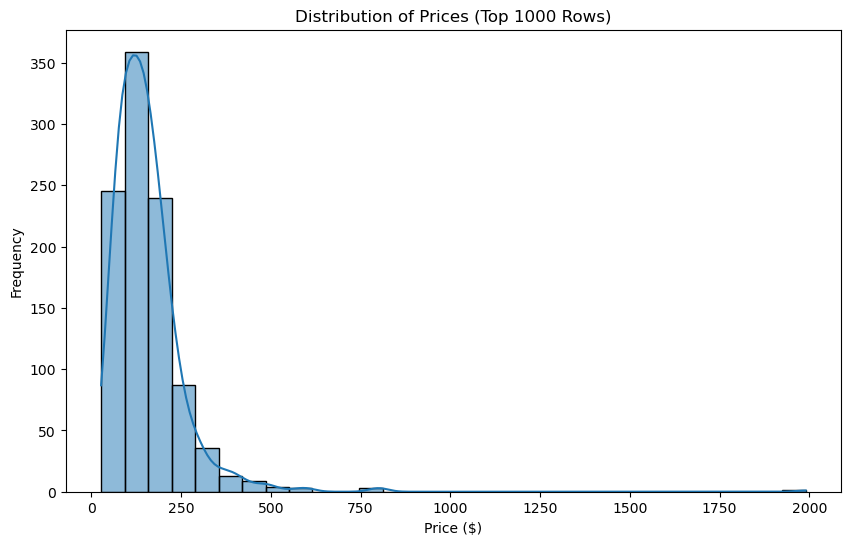

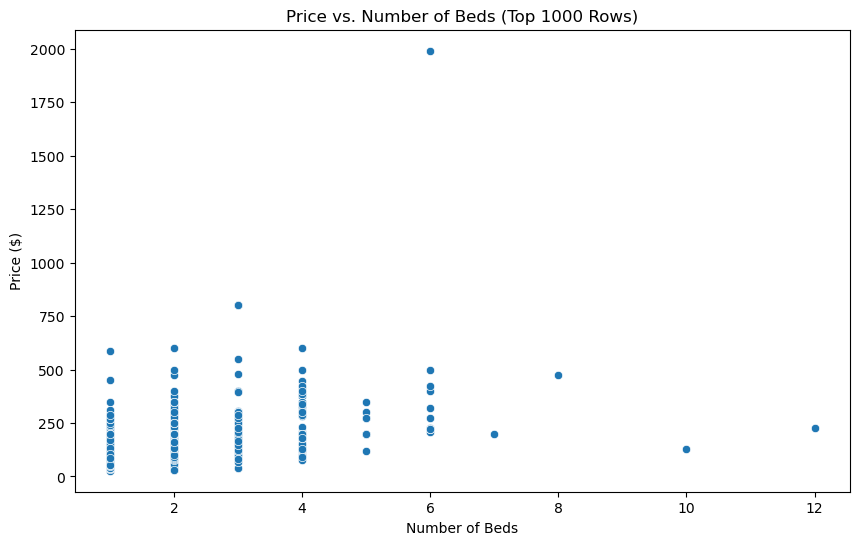

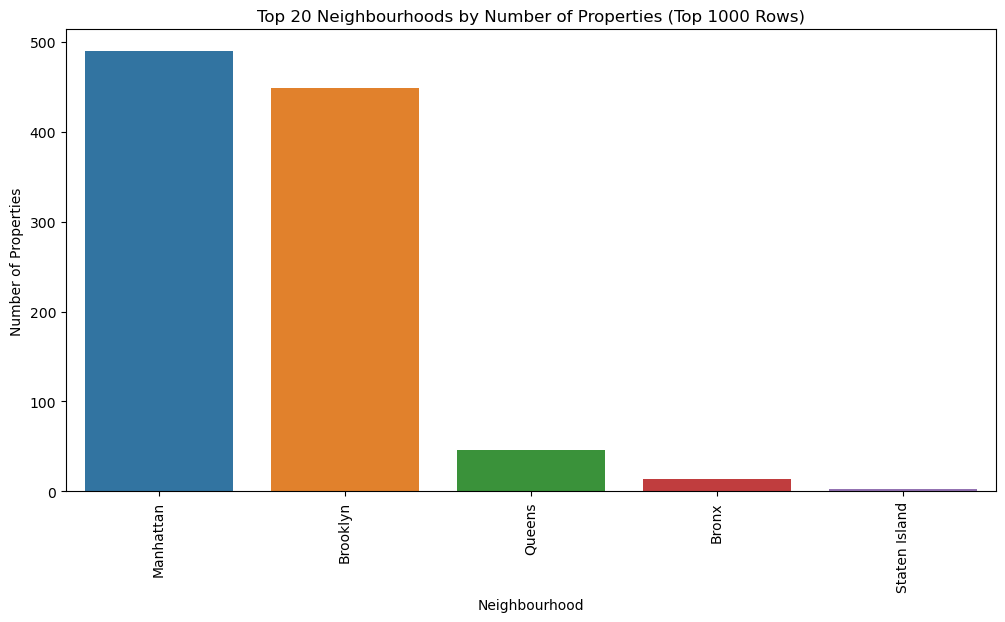

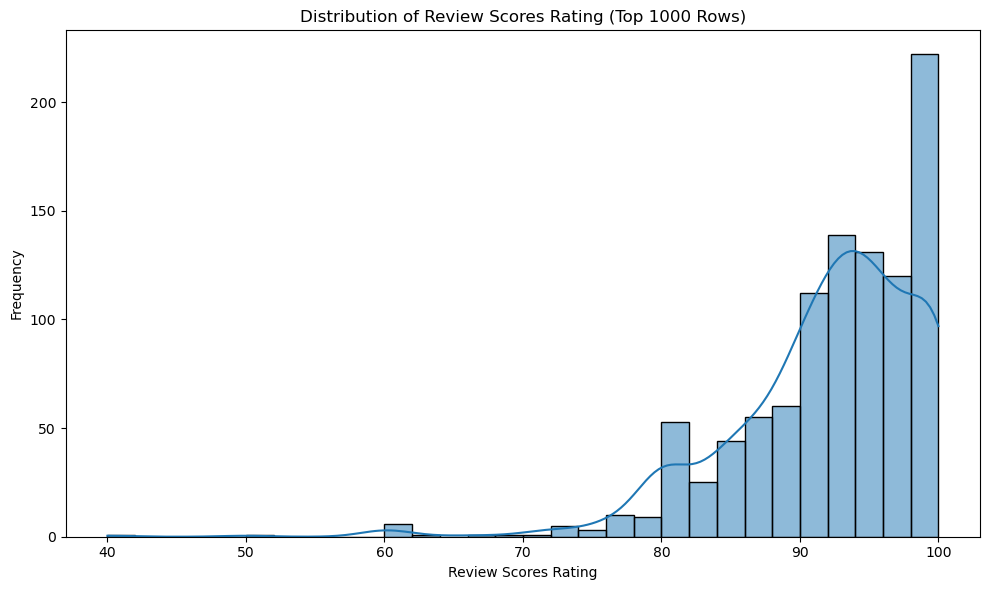

In [357]:

# Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned1['Price'], kde=True, bins=30)
plt.title('Distribution of Prices (Top 1000 Rows)')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# Relationship between Price and Number of Beds
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned1, x='Beds', y='Price')
plt.title('Price vs. Number of Beds (Top 1000 Rows)')
plt.xlabel('Number of Beds')
plt.ylabel('Price ($)')

# Distribution of Properties across Neighbourhoods
plt.figure(figsize=(12, 6))
neighbourhood_counts = df_cleaned1['Neighbourhood'].value_counts().head(20)  # Top 20 neighbourhoods
sns.barplot(x=neighbourhood_counts.index, y=neighbourhood_counts.values)
plt.title('Top 20 Neighbourhoods by Number of Properties (Top 1000 Rows)')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Properties')
plt.xticks(rotation=90)  # Rotate x-labels for better readability

# Review Scores Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned1['Review Scores Rating'], kde=True, bins=30)
plt.title('Distribution of Review Scores Rating (Top 1000 Rows)')
plt.xlabel('Review Scores Rating')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


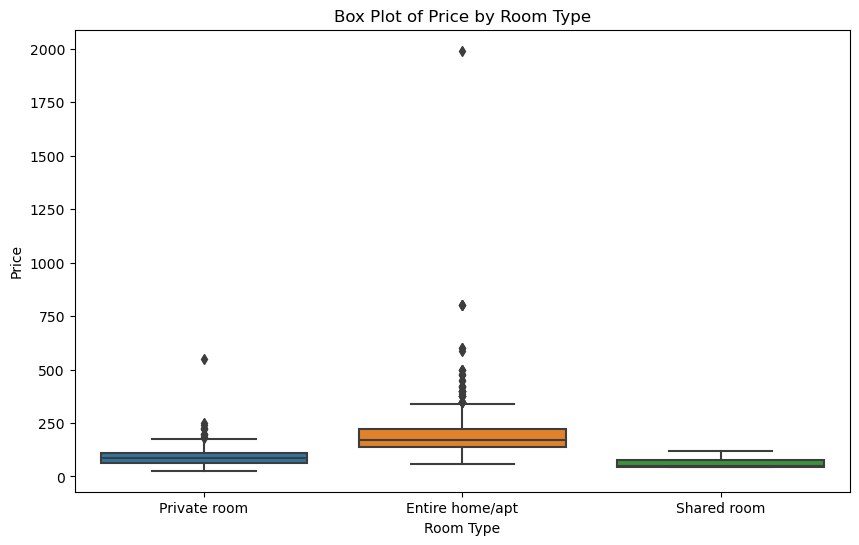

In [358]:
# plotting boxplot of Price by Room Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Room Type', y='Price', data=df_cleaned1)
plt.title('Box Plot of Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

In [359]:
# Dealing with outliers in 'Price'
# Calculating the Interquartile Range (IQR)
# Q1 = df_cleaned1['Price'].quantile(0.25)
# Q3 = df_cleaned1['Price'].quantile(0.75)
# IQR = Q3 - Q1

# # Defining the threshold for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Handling outliers by capping
# df_cleaned1['Price'] = df_cleaned1['Price'].clip(lower=lower_bound, upper=upper_bound)

# # Checking the revised data
# revised_data_info = df_cleaned1.info()
# revised_price_descriptive_stats = df_cleaned1['Price'].describe()
# revised_data_info, revised_price_descriptive_stats

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 4 to 1143
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Host Id                     1000 non-null   int64         
 1   Host Since                  1000 non-null   datetime64[ns]
 2   Name                        1000 non-null   object        
 3   Neighbourhood               1000 non-null   object        
 4   Property Type               1000 non-null   object        
 5   Review Scores Rating (bin)  1000 non-null   float64       
 6   Room Type                   1000 non-null   object        
 7   Zipcode                     1000 non-null   object        
 8   Beds                        1000 non-null   float64       
 9   Number Of Reviews           1000 non-null   int64         
 10  Price                       1000 non-null   float64       
 11  Review Scores Rating        1000 non-null   float64     

C:\Users\SaiKrishna\AppData\Local\Temp\ipykernel_21324\453027765.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned1['Price'] = df_cleaned1['Price'].clip(lower=lower_bound, upper=upper_bound)


(None,
 count    1000.000000
 mean      149.404000
 std        72.384403
 min        27.000000
 25%        95.000000
 50%       140.000000
 75%       190.000000
 max       332.500000
 Name: Price, dtype: float64)

In [384]:
df_cleaned['Host Since'] = pd.to_datetime(df_cleaned['Host Since'])

# Find the most recent 'Host Since' date in the dataset or use the current date
# recent_date = df['Host Since'].max()  # Uncomment this if you want to use the most recent date in the dataset
current_date = pd.to_datetime('now')   # Use the current actual date
# Calculate duration in years
df_cleaned['Host Duration'] = (current_date - df_cleaned['Host Since']).dt.days / 365

# Find the count of hosts with duration of more than 10 years
more_than_10_years = df_cleaned[df_cleaned['Host Duration'] > 10].shape[0]

print(f"Number of hosts staying more than 10 years: {more_than_10_years}")

Number of hosts staying more than 10 years: 13542


C:\Users\SaiKrishna\AppData\Local\Temp\ipykernel_21324\3823223685.py:5: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  current_date = pd.to_datetime('now')   # Use the current actual date


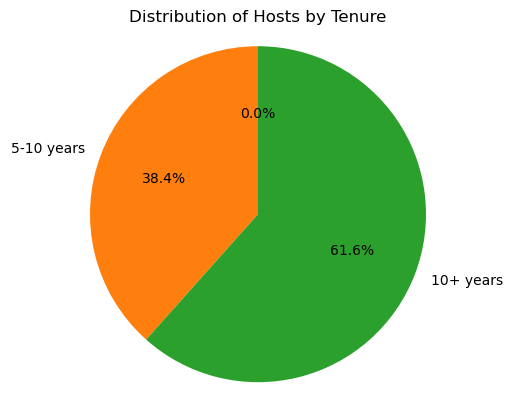

In [385]:
tenure_bins = [0, 5, 10, 15]
tenure_labels = ['0-5 years', '5-10 years', '10+ years']

# Categorize the tenure into bins
df_cleaned['Tenure Category'] = pd.cut(df_cleaned['Host Duration'], bins=tenure_bins, labels=tenure_labels, right=False)

# Count the occurrences of each tenure category
tenure_distribution = df_cleaned['Tenure Category'].value_counts(sort=False)  # Do not sort to maintain order of bins

# Plot pie chart
tenure_distribution.plot.pie(autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.title('Distribution of Hosts by Tenure')
plt.ylabel('')  # Hide y-axis label
plt.show()


In [386]:
property_counts = df_cleaned1.groupby(['Neighbourhood', 'Property Type']).size().reset_index(name='Counts')

# Find which property type is most common in each neighbourhood
most_common_properties = property_counts.loc[property_counts.groupby(['Neighbourhood'])['Counts'].idxmax()]
most_common_properties

,Neighbourhood,Property Type,Counts
1,Bronx,House,8
3,Brooklyn,Apartment,369
9,Manhattan,Apartment,468
16,Queens,Apartment,28
22,Staten Island,House,2


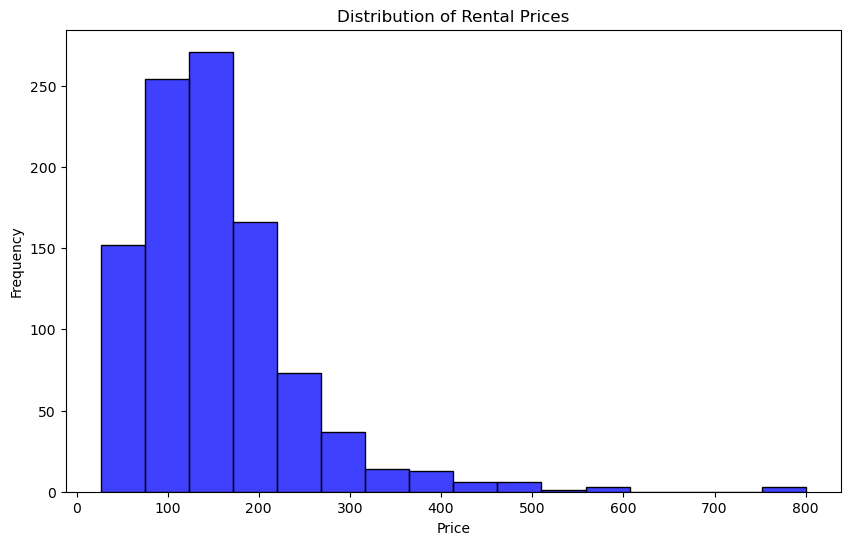

In [387]:
# plot distribution of rental prices
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned1[df_cleaned1['Price'] <= 1000], x='Price', bins="doane", kde=False, color='blue')
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [388]:
# Group by 'Neighbourhood' and calculate the average 'Price'
average_prices = df_cleaned1.groupby('Neighbourhood')['Price'].mean().reset_index()

# Find the neighbourhood with the highest average price
most_expensive_neighbourhood = average_prices.loc[average_prices['Price'].idxmax()]
most_expensive_neighbourhood

Neighbourhood     Manhattan
Price            177.196319
Name: 2, dtype: object

     Review Scores Rating  Number Of Reviews       Price
0                    40.0                  1   45.000000
1                    50.0                  2   99.000000
2                    60.0                  1  190.000000
3                    60.0                  2  130.333333
4                    62.0                 24  185.000000
..                    ...                ...         ...
609                 100.0                 13  500.000000
610                 100.0                 15  142.000000
611                 100.0                 18  230.000000
612                 100.0                 21  126.000000
613                 100.0                 22   70.000000

[614 rows x 3 columns]


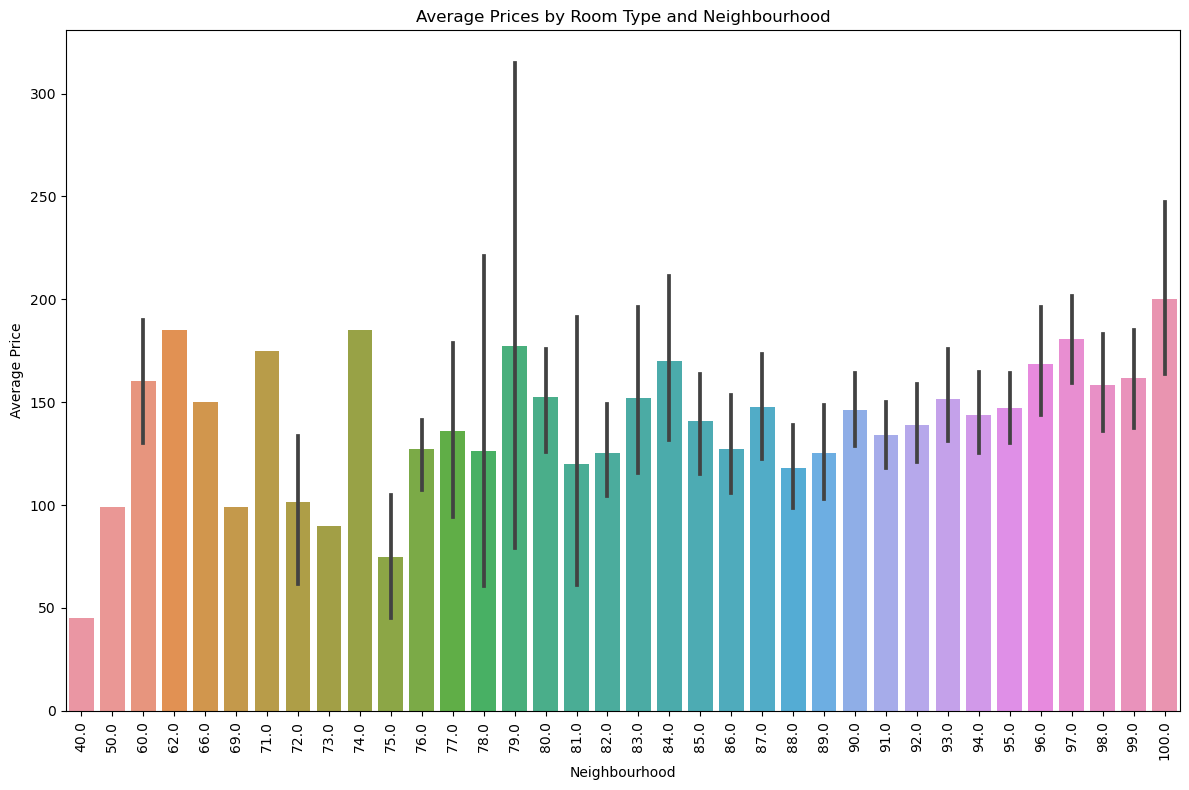

In [389]:
average_prices = df_cleaned1.groupby(['Review Scores Rating', 'Number Of Reviews'])['Price'].mean().reset_index()
print(average_prices)
# Now let's pivot the data to get Neighbourhood on the rows and Room Types on the columns
pivoted_data = average_prices.pivot(index='Review Scores Rating', columns='Number Of Reviews', values='Price')

# We can now plot this as a bar chart using seaborn.
plt.figure(figsize=(12, 8))
sns.barplot(x='Review Scores Rating', y='Price', data=average_prices)

# Improve the legibility of the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Average Prices by Room Type and Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price')

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

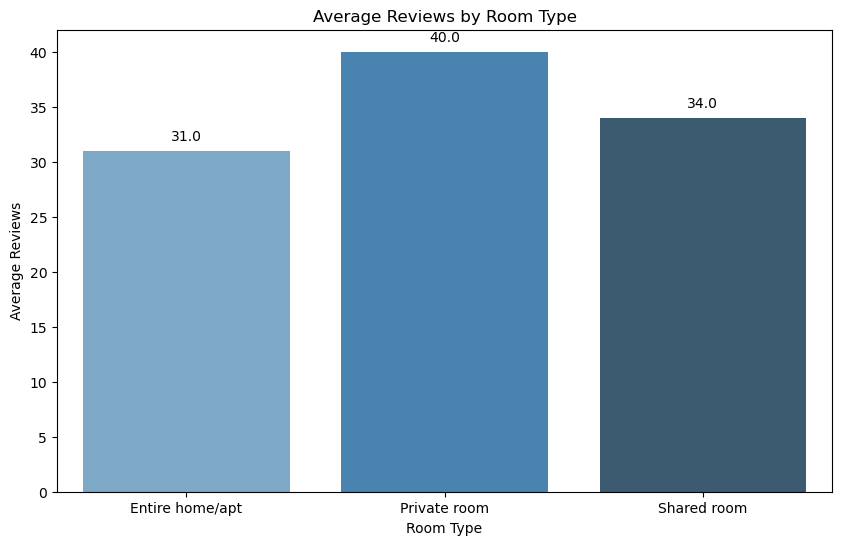

In [390]:
average_reviews_by_type = df_cleaned1.loc[:, ['Number Of Reviews', 'Room Type']].groupby('Room Type').mean()

# Convert the values to integers
average_reviews_by_type = average_reviews_by_type.astype(int)

# Reset the index to make 'room_type' a column again
average_reviews_by_type.reset_index(inplace=True)

# Rename the columns for better understanding
average_reviews_by_type.columns = ['Room Type', 'Number Of Reviews']

# Seaborn barplot for average reviews by room type with data labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Room Type', y='Number Of Reviews', data=average_reviews_by_type, palette='Blues_d')
plt.title('Average Reviews by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Reviews')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

C:\Users\SaiKrishna\AppData\Local\Temp\ipykernel_21324\729170844.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = grouped_data.pivot('Neighbourhood', 'Room Type', 'counts')


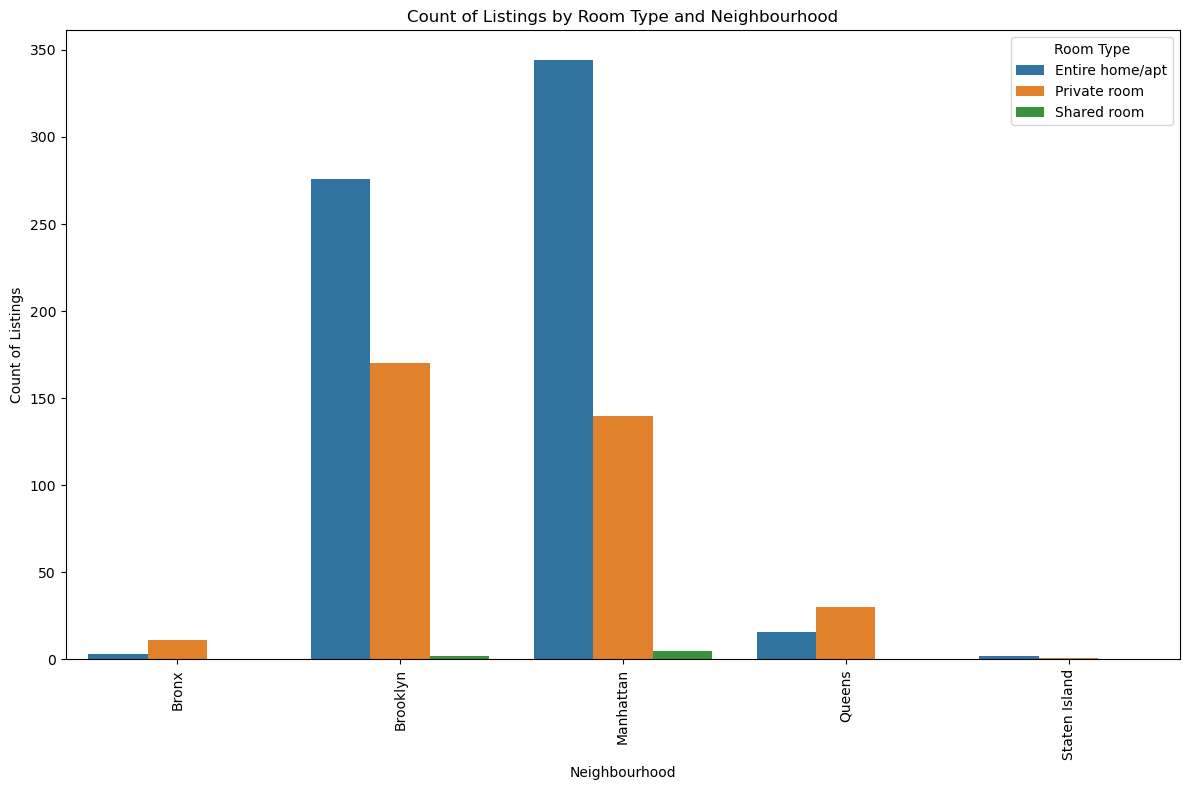

In [391]:
grouped_data = df_cleaned1.groupby(['Neighbourhood', 'Room Type']).size().reset_index(name='counts')

# Pivot the data to get a matrix-like structure
pivot_table = grouped_data.pivot('Neighbourhood', 'Room Type', 'counts')

# Create a bar plot
plt.figure(figsize=(12,8))
sns.barplot(x='Neighbourhood', y='counts', hue='Room Type', data=grouped_data)

# Improve Aesthetics
plt.xticks(rotation=90)
plt.xlabel('Neighbourhood')
plt.ylabel('Count of Listings')
plt.title('Count of Listings by Room Type and Neighbourhood')

plt.tight_layout()
plt.show()

C:\Users\SaiKrishna\AppData\Local\Temp\ipykernel_21324\2750507687.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Neighbourhood', y='Price', hue='Room Type', data=df_cleaned1, ci=None)


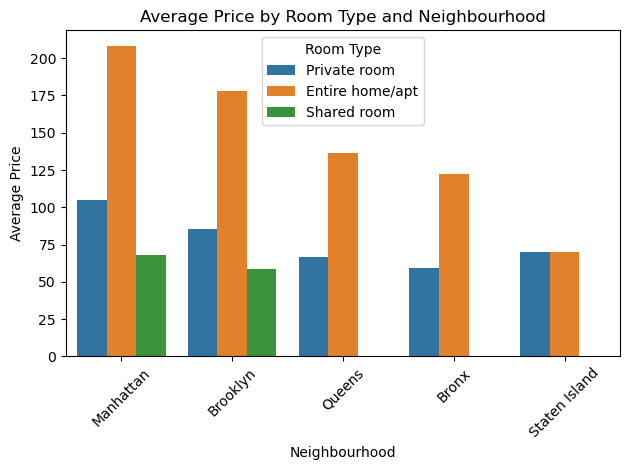

In [392]:
# bar chart for Average Price by Room Type and Neighbourhood
sns.barplot(x='Neighbourhood', y='Price', hue='Room Type', data=df_cleaned1, ci=None)

# Improve Aesthetics
plt.xticks(rotation=45) # Rotate the x labels to make them readable
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price')
plt.title('Average Price by Room Type and Neighbourhood')
plt.legend(title='Room Type')

# Display the plot
plt.tight_layout()
plt.show()

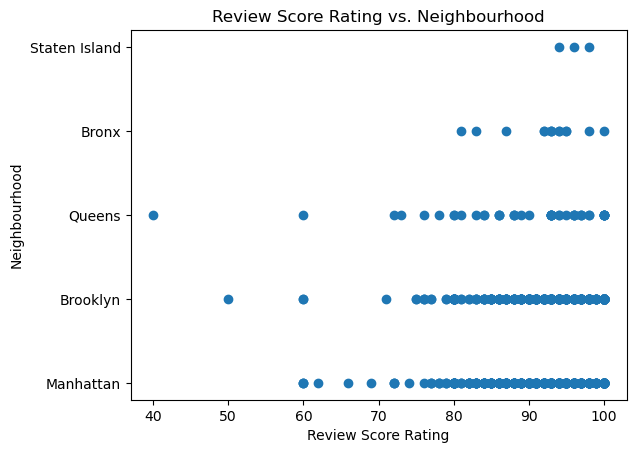

In [393]:
# scatter plot Review Score Rating vs. Neighbourhood
plt.scatter(df_cleaned1['Review Scores Rating'], df_cleaned1['Neighbourhood'])

# Create a title and labels
plt.title('Review Score Rating vs. Neighbourhood')
plt.xlabel('Review Score Rating')
plt.ylabel('Neighbourhood')

# Show the plot
plt.show()

In [394]:
# get maximum and minumum number of reviews
reviews = df_cleaned1.loc[: , 'Number Of Reviews']
max_reviews = np.max(reviews)
print('The maximum number of reviews for a single property is:', max_reviews)
min_reviews = np.min(reviews)
print('The minimum number of reviews for a single property is:', min_reviews)
average_reviews = np.mean(reviews)
print('The average number of reviews for a single property is:', int(average_reviews))
std_dev_reviews = np.std(reviews)
print('The standard deviation of the number of reviews for a single property is:', int(std_dev_reviews))


The maximum number of reviews for a single property is: 257
The minimum number of reviews for a single property is: 1
The average number of reviews for a single property is: 34
The standard deviation of the number of reviews for a single property is: 42


In [395]:
df_cleaned1.describe()

,Host Id,Review Scores Rating (bin),Beds,Number Of Reviews,Price,Review Scores Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,84903.273000,90.325000,1.689000,34.663000,155.825000,91.91500
std,55517.805181,7.370461,1.116927,42.322555,107.047688,7.13391
min,500.000000,40.000000,1.000000,1.000000,27.000000,40.00000
25%,38451.000000,85.000000,1.000000,6.000000,95.000000,89.00000
50%,72038.000000,90.000000,1.000000,18.000000,140.000000,93.00000
75%,131097.750000,95.000000,2.000000,48.000000,190.000000,97.00000
max,191475.000000,100.000000,12.000000,257.000000,1990.000000,100.00000


In [396]:
# Identify the neighbourhood or neighbourhood group with the highest average price
highest_priced_listing = df_cleaned1.loc[df_cleaned1['Price'].idxmax()]
print("The highest priced Airbnb is located in:", highest_priced_listing['Neighbourhood'])
print("The price is:", highest_priced_listing['Price'])
average_prices = df_cleaned1.groupby('Neighbourhood')['Price'].mean()

highest_avg_price_neighbourhood = average_prices.idxmax()
print("The neighborhood group with the highest average price is:", highest_avg_price_neighbourhood)
print("The average price is:", average_prices[highest_avg_price_neighbourhood])


The highest priced Airbnb is located in: Manhattan
The price is: 1990
The neighborhood group with the highest average price is: Manhattan
The average price is: 177.19631901840492


Correlation between price and number of reviews: -0.12378520506146606


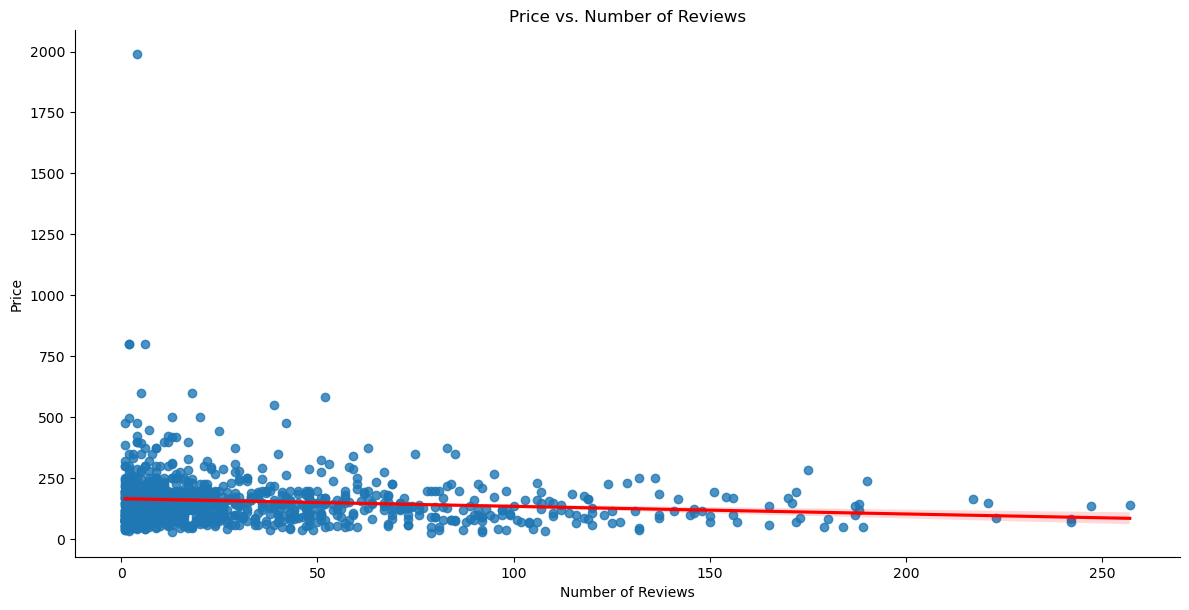

In [397]:
# Calculate the correlation to see if there's a linear relationship
correlation = df_cleaned1['Number Of Reviews'].corr(df_cleaned1['Price'])
print(f"Correlation between price and number of reviews: {correlation}")

# Create a scatter plot with a regression line to show the relationship visually
sns.lmplot(x='Number Of Reviews', y='Price', data=df_cleaned1, aspect=2, height=6, line_kws={'color': 'red'})
plt.title('Price vs. Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')

plt.show()

In [398]:
correlation = df_cleaned1['Review Scores Rating'].corr(df_cleaned1['Price'])
print(f"The correlation coefficient between review scores rating and price is: {correlation}")

The correlation coefficient between review scores rating and price is: 0.11186863248852301


In [399]:
numerical_cols = ['Host Id','Zipcode', 'Beds',
        'Number Of Reviews', 'Review Scores Rating (bin)', 'Price',
       'Review Scores Rating']
categorical_cols = ['Name', 'Neighbourhood ', 'Property Type','Room Type']

# Data Visualization using Matplotlib and Seaborn
# Boxplot to visualize the distribution of 'Price' based on 'Room Type'

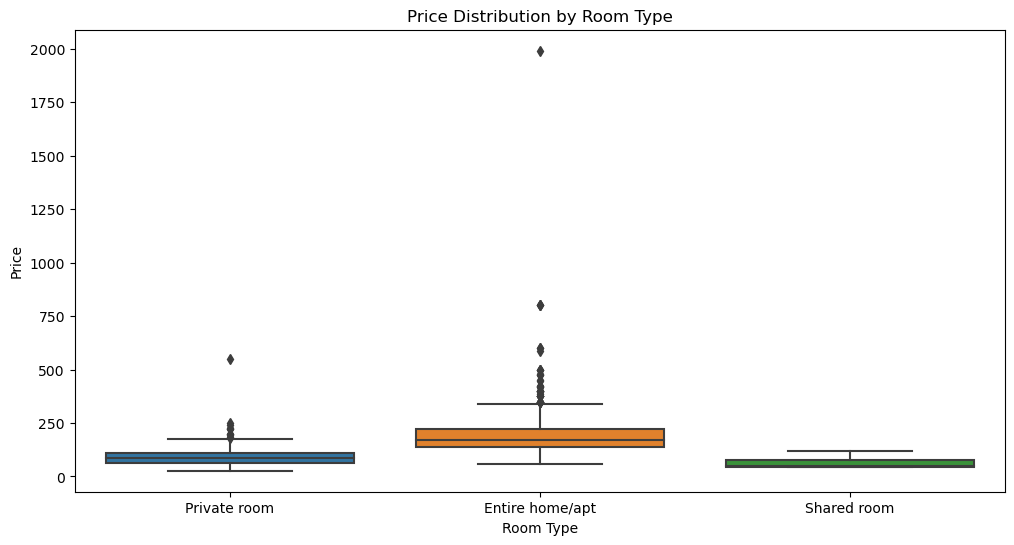

In [400]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Room Type', y='Price', data=df_cleaned1.head(1000))
plt.title('Price Distribution by Room Type')
plt.show()

Manhattan        489
Brooklyn         448
Queens            46
Bronx             14
Staten Island      3
Name: Neighbourhood, dtype: int64


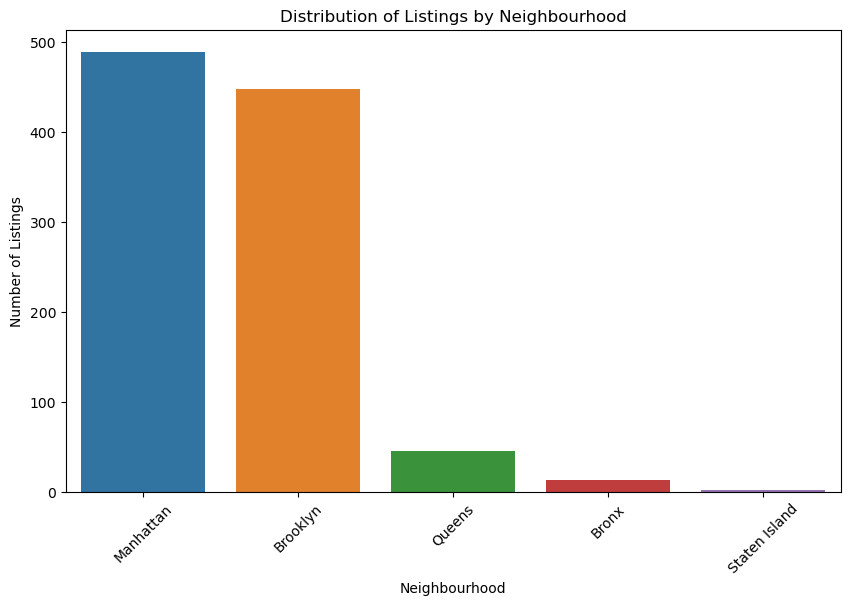

In [401]:
# Number of listings for each Neighbourhood, Plot for 1000 records 
neighbour_counts = df_cleaned1['Neighbourhood'].value_counts()
print(neighbour_counts)
#print(df_cleaned1.columns)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned1, x='Neighbourhood')
plt.title('Distribution of Listings by Neighbourhood')
plt.xticks(rotation=45)
plt.xlabel('Neighbourhood')  # Label for the x-axis
plt.ylabel('Number of Listings')  # Label for the y-axis
plt.show()

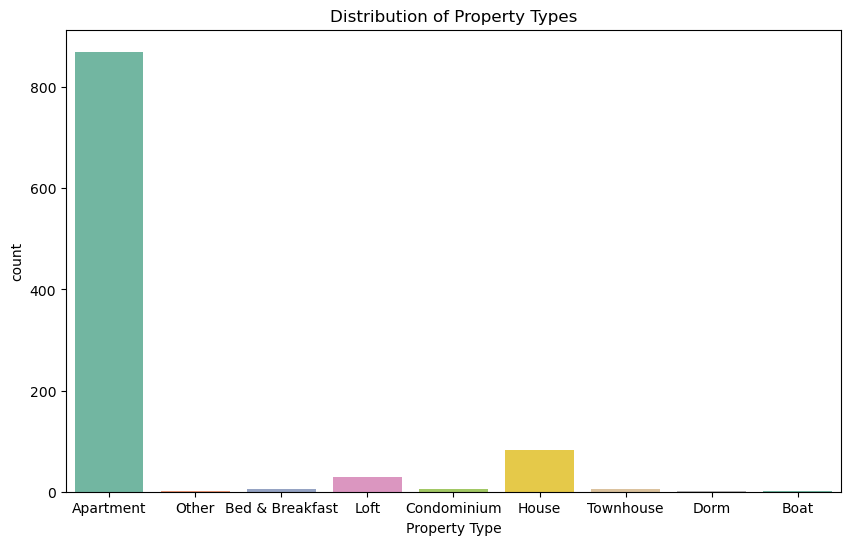

In [402]:
# Plot Room Type
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned1, x='Property Type', palette='Set2')
plt.title('Distribution of Property Types')
plt.show()

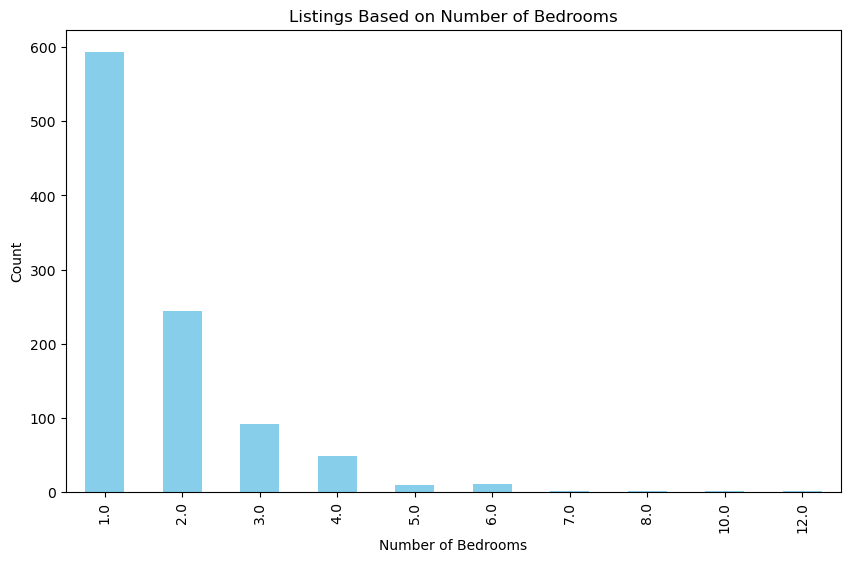

In [403]:
bedroom_counts = df_cleaned1['Beds'].value_counts().sort_index()
# Create a bar plot to analyze the listings based on the number of bedrooms
plt.figure(figsize=(10, 6))
bedroom_counts.plot(kind='bar', color='skyblue')
plt.title('Listings Based on Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')
plt.show()

In [404]:
# Sort the listings based on price in descending order to fetch listings with higher prices
listings_high_prices = df_cleaned1.sort_values(by='Price', ascending=False)

# Display the top 10 listings with higher prices
top_high_price_listings = listings_high_prices.head(10)
top_high_price_listings

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number Of Reviews,Price,Review Scores Rating
101,8730,2009-02-27,Comfort & Convenience,Manhattan,Condominium,100.0,Entire home/apt,10003,6.0,4,1990,100.0
680,94735,2010-03-16,3BR/3Bth - Broadway/Upper West Side,Manhattan,Apartment,100.0,Entire home/apt,10023,3.0,6,800,100.0
1061,176903,2010-07-21,SunGalore: Luxury 2bd/2bth Apart,Manhattan,Apartment,100.0,Entire home/apt,10014,3.0,2,800,100.0
1060,176903,2010-07-21,LUXURY2bd2bth24hDrm-West Village,Manhattan,Apartment,100.0,Entire home/apt,10014,3.0,2,800,100.0
92,8057,2009-02-17,HUGE MODERN LUXURY-2bed/2bath+patio,Manhattan,Loft,100.0,Entire home/apt,10009,2.0,5,600,100.0
589,74303,2010-01-27,perfect for a family or small group,Brooklyn,Apartment,90.0,Entire home/apt,11201,4.0,18,600,92.0
165,19969,2009-06-03,SoHo Loft - Entire Floor,Manhattan,Apartment,95.0,Entire home/apt,10013,1.0,52,585,96.0
4,500,2008-06-26,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036,3.0,39,549,96.0
571,72062,2010-01-20,KING WESTON - 3 BR E. VILLAGE,Manhattan,Apartment,90.0,Entire home/apt,10009,6.0,20,500,94.0
1033,170703,2010-07-18,Large Designer Luxury Loft in NoHo,Manhattan,Apartment,100.0,Entire home/apt,10003,2.0,13,500,100.0


In [405]:
# Determine the threshold for 'pricey' and 'cheap'. 
# Let's say you define 'pricey' places as those in the top 25% of your price range and 'cheap' as those in the bottom 25%.

pricey_threshold = df_cleaned1['Price'].quantile(0.75)
cheap_threshold = df_cleaned1['Price'].quantile(0.25)

# Categorize accommodations based on price
df_cleaned1['price_category'] = pd.cut(df_cleaned1['Price'], 
                              bins=[0, cheap_threshold, pricey_threshold, df_cleaned1['Price'].max()], 
                              labels=['cheap', 'moderate', 'pricey'])

# Summarize review counts for each category
review_counts_by_price = df_cleaned1.groupby('price_category')['Number Of Reviews'].sum()

# Assess review sentiments for each category
# Assuming review sentiment is a score from 0 to 100, where >=50 is 'good' and <50 is 'bad'
df_cleaned1['review_sentiment'] = pd.cut(df_cleaned1['Review Scores Rating'],
                                bins=[0, 50, 100],
                                labels=['bad', 'good'])

# You can then aggregate this data to get the count of good and bad reviews for the price categories
sentiment_by_price_category = df_cleaned1.groupby(['price_category', 'review_sentiment']).size().unstack()

# Results - this contains the total number of reviews and sentiments for each price category
print(review_counts_by_price)
print(sentiment_by_price_category)

price_category
cheap       10386
moderate    17759
pricey       6518
Name: Number Of Reviews, dtype: int64
review_sentiment  bad  good
price_category             
cheap               1   259
moderate            1   491
pricey              0   248


C:\Users\SaiKrishna\AppData\Local\Temp\ipykernel_21324\2759203952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned1['price_category'] = pd.cut(df_cleaned1['Price'],
C:\Users\SaiKrishna\AppData\Local\Temp\ipykernel_21324\2759203952.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned1['review_sentiment'] = pd.cut(df_cleaned1['Review Scores Rating'],


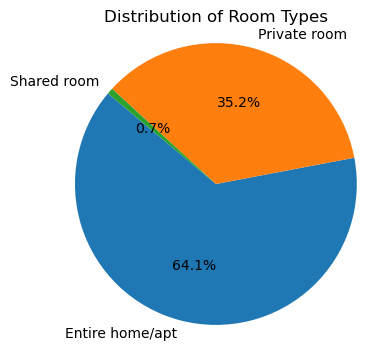

In [406]:
room_type_counts = df_cleaned1['Room Type'].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(room_type_counts, labels=room_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Room Types')
plt.show()

C:\Users\SaiKrishna\AppData\Local\Temp\ipykernel_21324\2826192417.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_cleaned1.corr()


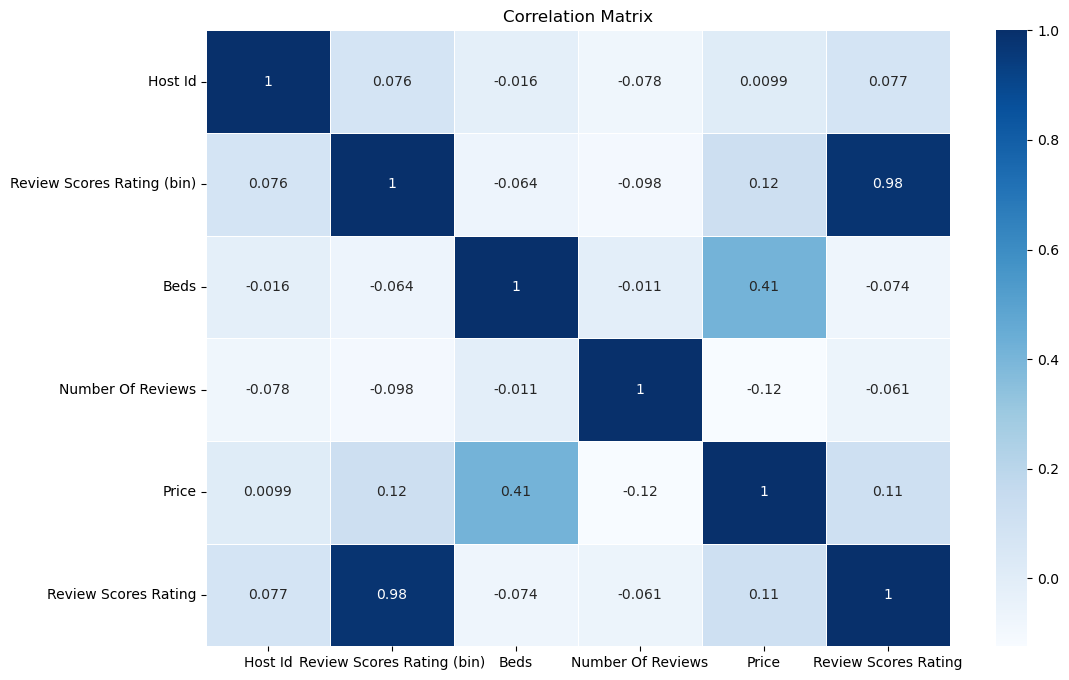

In [407]:
# Correlation between different variables
#df_cleaned1.drop(['Number of Records'], axis=1, inplace=True)
correlation_matrix = df_cleaned1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

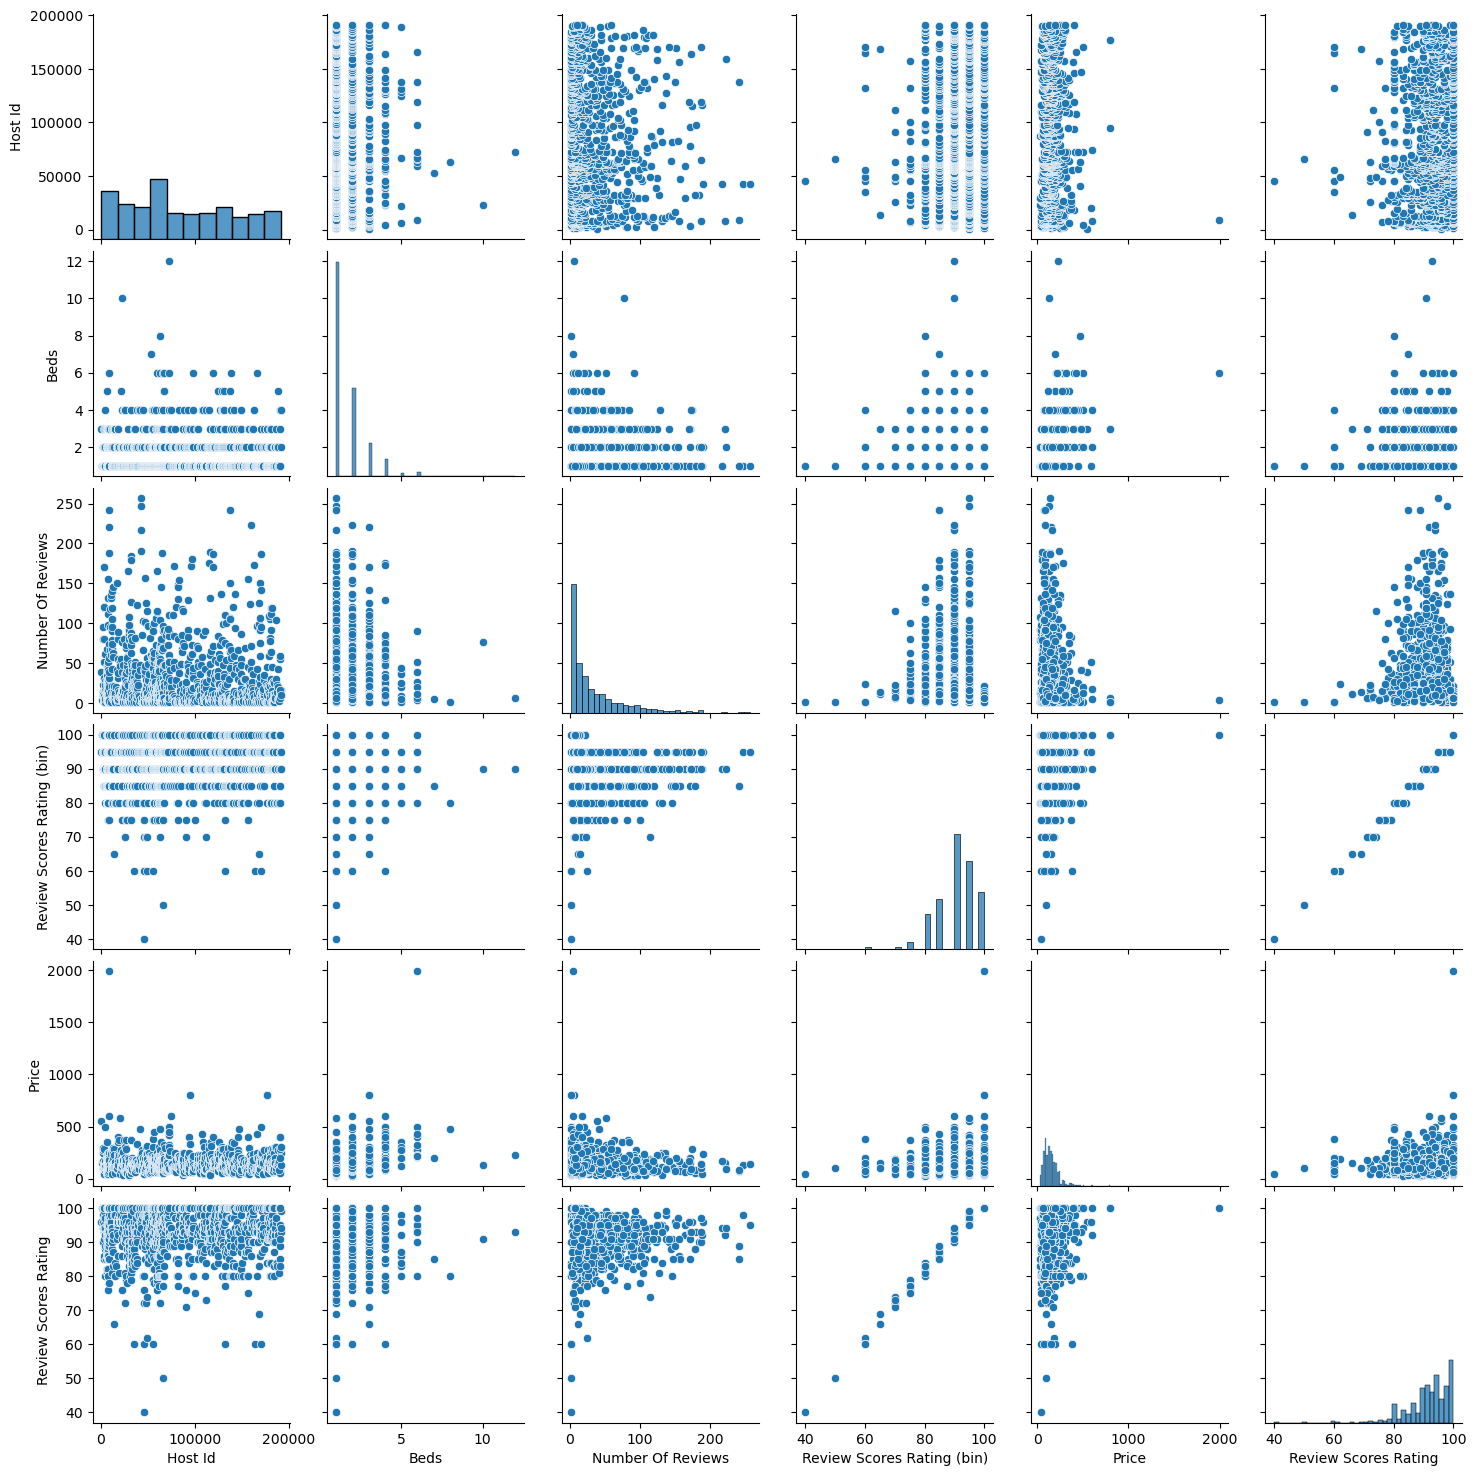

In [408]:
sns.pairplot(df_cleaned1[numerical_cols])
plt.show()

In [409]:
selected_columns = ['Price', 'Review Scores Rating', 'Neighbourhood', 'Room Type', 'Beds', 'Number Of Reviews']
airbnb_subset = df_cleaned1[selected_columns].dropna().head(1000)  # Using top 1000 rows

# Getting dummies for categorical variables
airbnb_processed = pd.get_dummies(airbnb_subset, columns=['Neighbourhood', 'Room Type'])
# print(airbnb_processed)
# Creating a binary target variable for review scores (High = 1 if score >= 90, Low = 0 if score < 90)
airbnb_processed['High_Review_Score'] = (airbnb_processed['Review Scores Rating'] >= 90).astype(int)

# Selecting features and target variable
X = airbnb_processed.drop(['Review Scores Rating', 'High_Review_Score'], axis=1)
y = airbnb_processed['High_Review_Score']
# print(X)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred = dt_classifier.predict(X_test)
# print(y_pred)
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)
print(accuracy)
print(classification_report_output)
# (accuracy, classification_report_output)

[0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0
 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1
 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1
 1 1 1 0]
0.66
              precision    recall  f1-score   support

           0       0.37      0.34      0.35        83
           1       0.76      0.78      0.77       217

    accuracy                           0.66       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.65      0.66      0.65       300



In [418]:
X = airbnb_processed.drop(['Price', 'Review Scores Rating', 'High_Review_Score'], axis=1)
y = airbnb_processed['Price']

# Splitting the data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_reg, y_train_reg)
y_pred_lr = lr_model.predict(X_test_reg)

# Applying Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_model.predict(X_test_reg)
# print(X_test_reg)
# Applying Decision Tree Regressor
dt_reg_model = DecisionTreeRegressor(random_state=42)
dt_reg_model.fit(X_train_reg, y_train_reg)
y_pred_dt = dt_reg_model.predict(X_test_reg)

# Evaluation metrics for each model
mse_lr = mean_squared_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)

mse_rf = mean_squared_error(y_test_reg, y_pred_rf)
r2_rf = r2_score(y_test_reg, y_pred_rf)

mse_dt = mean_squared_error(y_test_reg, y_pred_dt)
r2_dt = r2_score(y_test_reg, y_pred_dt)

print({"Linear Regression": {"MSE": mse_lr, "R2": r2_lr},
 "Random Forest": {"MSE": mse_rf, "R2": r2_rf},
 "Decision Tree": {"MSE": mse_dt, "R2": r2_dt}})

# print(dt_reg_model.predict([[4, 20, 0,0,1,0,0,1,0,0]]))
# print(rf_model.predict([[4, 20, 0,0,1,0,0,1,0,0]]))
# print(lr_model.predict([[4, 20, 0,0,1,0,0,1,0,0]]))

{'Linear Regression': {'MSE': 4165.663857640096, 'R2': 0.45134897415578024}, 'Random Forest': {'MSE': 5809.595070678184, 'R2': 0.23483017252552973}, 'Decision Tree': {'MSE': 19192.520748740182, 'R2': -1.5278074653143419}}


In [419]:
# Using 'High_Review_Score' as the target variable
X = airbnb_processed.drop(['Review Scores Rating', 'High_Review_Score'], axis=1)
y = airbnb_processed['High_Review_Score']

# Splitting the data into training and testing sets for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying Logistic Regression
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_cls, y_train_cls)
y_pred_log_reg = log_reg_model.predict(X_test_cls)

# Evaluation metrics for Logistic Regression
accuracy_log_reg = accuracy_score(y_test_cls, y_pred_log_reg)
classification_report_log_reg = classification_report(y_test_cls, y_pred_log_reg)
print(accuracy_log_reg*100)
print(classification_report_log_reg)
# (accuracy_log_reg, classification_report_log_reg)

73.5
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        54
           1       0.73      1.00      0.85       146

    accuracy                           0.73       200
   macro avg       0.87      0.51      0.44       200
weighted avg       0.81      0.73      0.63       200



C:\Users\SaiKrishna\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [420]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_cls, y_train_cls)
y_pred_knn = knn_model.predict(X_test_cls)

# Evaluation metrics for K-Nearest Neighbors Classifier
accuracy_knn = accuracy_score(y_test_cls, y_pred_knn)

accuracy_knn*100

69.0

In [421]:
numerical_features = airbnb_subset.select_dtypes(include=['float64', 'int64'])
numerical_features_scaled = StandardScaler().fit_transform(numerical_features)

# Applying KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(numerical_features_scaled)

# Adding the cluster information to the dataset
airbnb_subset['Cluster'] = clusters

# Displaying the first few rows with cluster labels
airbnb_subset.head()

C:\Users\SaiKrishna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Price,Review Scores Rating,Neighbourhood,Room Type,Beds,Number Of Reviews,Cluster
4,549,96.0,Manhattan,Private room,3.0,39,0
5,149,100.0,Brooklyn,Entire home/apt,1.0,4,2
6,250,100.0,Manhattan,Entire home/apt,1.0,9,2
7,90,94.0,Brooklyn,Private room,1.0,80,1
8,270,90.0,Manhattan,Entire home/apt,2.0,95,1


                          feature  importance       std
8              Property Type_Boat    0.000000  0.000000
10             Property Type_Dorm    0.000212  0.000014
13            Property Type_Other    0.003359  0.000100
6     Neighbourhood_Staten Island    0.069628  0.001313
5            Neighbourhood_Queens    0.114947  0.001850
7   Property Type_Bed & Breakfast    0.179074  0.001802
14        Property Type_Townhouse    0.307649  0.007411
16          Room Type_Shared room    0.602545  0.003730
11            Property Type_House    0.823707  0.005581
12             Property Type_Loft    1.176083  0.013528
3          Neighbourhood_Brooklyn    3.841334  0.072886
4         Neighbourhood_Manhattan    6.898732  0.066286
2            Review Scores Rating   13.107532  0.077718
9       Property Type_Condominium   16.443018  0.152076
0                            Beds   16.950469  0.091498
15         Room Type_Private room   19.441673  0.066641
1               Number Of Reviews   20.040038  0

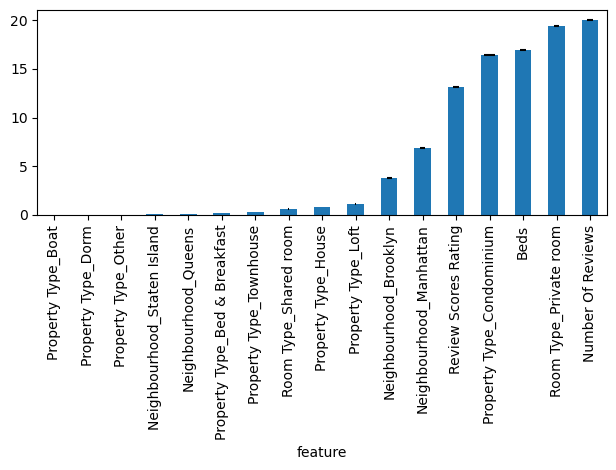

In [422]:
# feature importance for each variable
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=1)
cols = ['Beds', 'Number Of Reviews', 'Review Scores Rating',
       'Neighbourhood_Brooklyn', 'Neighbourhood_Manhattan',
       'Neighbourhood_Queens', 'Neighbourhood_Staten Island',
       'Property Type_Bed & Breakfast', 'Property Type_Boat',
       'Property Type_Condominium', 'Property Type_Dorm',
       'Property Type_House', 'Property Type_Loft', 'Property Type_Other',
       'Property Type_Townhouse', 'Room Type_Private room',
       'Room Type_Shared room']
random_forest_model.fit(train_X[cols], train_y)
importances = random_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
df = pd.DataFrame({'feature': train_X[cols].columns, 'importance': importances*100, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='bar', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [423]:

train_predictions = dt_reg_model.predict(X_train_reg)
validation_predictions = dt_reg_model.predict(X_test_reg)
ful_grown_train_rmse = sqrt(mean_squared_error(y_train_reg, train_predictions))
ful_grown_valid_rmse = sqrt(mean_squared_error(y_test_reg, validation_predictions))
print(ful_grown_train_rmse)
print(ful_grown_valid_rmse)

37.779869996799995
138.53707355340006


In [424]:
regressionSummary(train_y, dt_reg_model.predict(X_train_reg))
regressionSummary(valid_y, dt_reg_model.predict(X_test_reg))


Regression statistics

                      Mean Error (ME) : -0.2638
       Root Mean Squared Error (RMSE) : 151.0782
            Mean Absolute Error (MAE) : 92.2856
          Mean Percentage Error (MPE) : -34.6258
Mean Absolute Percentage Error (MAPE) : 72.6417

Regression statistics

                      Mean Error (ME) : -12.8163
       Root Mean Squared Error (RMSE) : 173.4409
            Mean Absolute Error (MAE) : 95.5390
          Mean Percentage Error (MPE) : -39.7986
Mean Absolute Percentage Error (MAPE) : 78.5894


In [425]:
train_errors = y_train_reg - train_predictions
validation_errors = y_test_reg - validation_predictions
error_df = pd.DataFrame({'Training Errors': train_errors, 'Validation Errors': validation_errors})
error_df

,Training Errors,Validation Errors
4,0.000000,NaN
5,-0.833333,NaN
6,37.400000,NaN
7,0.000000,NaN
8,0.000000,NaN
...,...,...
1139,NaN,150.0
1140,0.000000,NaN
1141,-4.666667,NaN
1142,NaN,64.0


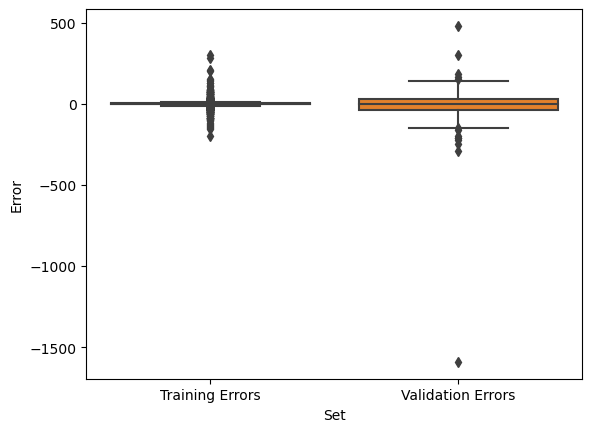

In [426]:
errors_df_new = error_df.melt(var_name='Set', value_name='Error')
sns.boxplot(x="Set", y="Error", data=errors_df_new)
plt.show()

In [427]:
pruned_tree = DecisionTreeRegressor(max_depth=5, random_state=1)
pruned_tree.fit(X_train_reg, y_train_reg)

# Evaluating the pruned tree using cross-validation on the training set
cross_val_scores = cross_val_score(pruned_tree, X_train_reg, y_train_reg, cv=10, scoring='neg_mean_squared_error')
avg_cv_score = np.mean(np.sqrt(-cross_val_scores))

# Predictions for the validation set using the pruned tree
y_validation_pred_pruned = pruned_tree.predict(X_test_reg)

# RMS error for the pruned tree on the validation set
rms_error_validation_pruned = mean_squared_error(y_test_reg, y_validation_pred_pruned, squared=False)

avg_cv_score, rms_error_validation_pruned


(102.94086550329408, 132.18005570170575)

In [428]:
param_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 20, 2),
    'min_samples_leaf': range(1, 10)
}

# Setting up GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=1), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fitting GridSearchCV to the training data
grid_search.fit(X_train_reg, y_train_reg)

# Best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Creating a regression tree with the best parameters
fine_tuned_tree = DecisionTreeRegressor(**best_params, random_state=1)
fine_tuned_tree.fit(X_train_reg, y_train_reg)

# Predicting on the validation set
y_validation_pred_fine_tuned = fine_tuned_tree.predict(X_test_reg)

# Calculating RMS error for the fine-tuned tree on the validation set
rms_error_validation_fine_tuned = mean_squared_error(y_test_reg, y_validation_pred_fine_tuned, squared=False)

best_params, rms_error_validation_fine_tuned

({'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2},
 66.12216351225213)

In [429]:
regressionSummary(y_train_reg, fine_tuned_tree.predict(X_train_reg))
regressionSummary(y_test_reg, fine_tuned_tree.predict(X_test_reg))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 87.9901
            Mean Absolute Error (MAE) : 48.6955
          Mean Percentage Error (MPE) : -15.1920
Mean Absolute Percentage Error (MAPE) : 33.1597

Regression statistics

                      Mean Error (ME) : -3.3697
       Root Mean Squared Error (RMSE) : 66.1222
            Mean Absolute Error (MAE) : 41.2716
          Mean Percentage Error (MPE) : -14.6642
Mean Absolute Percentage Error (MAPE) : 29.7225


In [430]:
train_predictions1 = fine_tuned_tree.predict(X_train_reg)
validation_predictions1 = fine_tuned_tree.predict(X_test_reg)
train_rmse1 = sqrt(mean_squared_error(y_train_reg, train_predictions1))
valid_rmse1 = sqrt(mean_squared_error(y_test_reg, validation_predictions1))
print(train_rmse1)
print(valid_rmse1)

train_errors1 = y_train_reg - train_predictions1
validation_errors1 = y_test_reg - validation_predictions1
error_df1 = pd.DataFrame({'Training Errors': train_errors1, 'Validation Errors': validation_errors1})
error_df1

87.99009950962157
66.12216351225213


,Training Errors,Validation Errors
4,331.250000,NaN
5,5.988372,NaN
6,71.217105,NaN
7,7.058394,NaN
8,36.764228,NaN
...,...,...
1139,NaN,16.764228
1140,165.764228,NaN
1141,21.217105,NaN
1142,NaN,55.764228


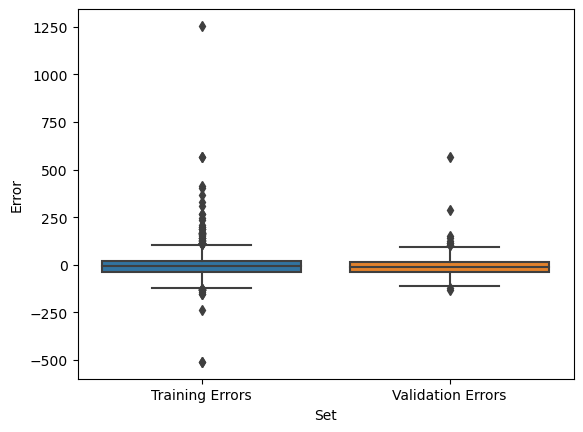

In [432]:
errors_df_new1 = error_df1.melt(var_name='Set', value_name='Error')
sns.boxplot(x="Set", y="Error", data=errors_df_new1)
plt.show()

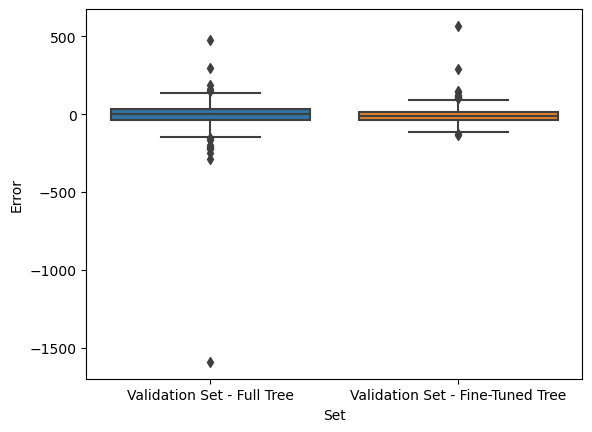

In [433]:
validation_errors2 = y_test_reg - y_validation_pred_fine_tuned

error_df2 = pd.DataFrame({'Validation Set - Full Tree': validation_errors, 'Validation Set - Fine-Tuned Tree': validation_errors2})
error_df2
errors_df_new2 = error_df2.melt(var_name='Set', value_name='Error')
sns.boxplot(x="Set", y="Error", data=errors_df_new2)
plt.show()

In [434]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.37      0.35       104
           1       0.77      0.74      0.75       296

    accuracy                           0.64       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.65      0.64      0.65       400



In [435]:
# Load and preprocess data
df_cleaned2 = df_cleaned.head(1000)
numerical_cols1 = ['Beds', 'Number Of Reviews', 'Price', 'Review Scores Rating']
df_cleaned2.set_index('Neighbourhood', inplace=True)
df_cleaned3 = df_cleaned2[numerical_cols1].apply(lambda x: x.astype('float64'))

# Normalized distance
df_cleaned2_norm = df_cleaned3.apply(preprocessing.scale, axis=0)
# print(df_cleaned2_norm)
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_cleaned2_norm)
# print(kmeans)
# Cluster membership
memb = pd.Series(kmeans.labels_, index=df_cleaned2_norm.index)
# print(memb)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

C:\Users\SaiKrishna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0 :  Brooklyn, Manhattan, Manhattan, Brooklyn, Manhattan, Queens, Brooklyn, Queens, Queens, Queens, Manhattan, Brooklyn, Manhattan, Manhattan, Brooklyn, Manhattan, Manhattan, Queens, Manhattan, Brooklyn, Manhattan, Brooklyn, Manhattan, Brooklyn, Brooklyn, Manhattan, Manhattan, Manhattan, Manhattan, Brooklyn, Manhattan, Manhattan, Brooklyn, Brooklyn, Manhattan, Manhattan, Brooklyn, Manhattan, Brooklyn, Manhattan, Manhattan, Manhattan, Brooklyn, Brooklyn, Brooklyn, Manhattan, Manhattan, Brooklyn, Brooklyn, Manhattan, Manhattan, Brooklyn, Manhattan, Manhattan, Brooklyn, Brooklyn, Brooklyn, Manhattan, Manhattan, Manhattan, Brooklyn, Brooklyn, Brooklyn, Brooklyn, Brooklyn, Manhattan, Brooklyn, Brooklyn, Manhattan, Manhattan, Manhattan, Brooklyn, Manhattan, Queens, Brooklyn, Manhattan, Manhattan, Brooklyn, Manhattan, Brooklyn, Manhattan, Manhattan, Manhattan, Brooklyn, Brooklyn, Brooklyn, Manhattan, Manhattan, Manhattan, Brooklyn, Manhattan, Manhattan, Brooklyn, Brooklyn, Brooklyn, Brooklyn,

In [436]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_cleaned2_norm.columns)
pd.set_option('display.precision', 3)
print(centroids)
pd.reset_option('display.precision')

    Beds  Number Of Reviews   Price  Review Scores Rating
0 -0.551             -0.371  -0.268                 0.490
1  2.832             -0.150   1.991                -0.057
2  0.698             -0.300   0.462                 0.341
3 -0.225              1.991  -0.351                -0.118
4 -0.061             -0.363  -0.235                -1.592
5  3.862             -0.725  17.143                 1.134


In [437]:
withinClusterSS = [0] * 6
clusterCount = [0] * 6
for cluster, distance in zip(kmeans.labels_, kmeans.transform(df_cleaned2_norm)):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1
for cluster, withClustSS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster, 
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (433 members): 329.99 within cluster
Cluster 1 (47 members): 271.58 within cluster
Cluster 2 (207 members): 313.35 within cluster
Cluster 3 (146 members): 299.32 within cluster
Cluster 4 (166 members): 338.10 within cluster
Cluster 5 (1 members):  0.00 within cluster


,Beds,Number Of Reviews,Price,Review Scores Rating,cluster
0,-0.550980,-0.370872,-0.268155,0.490311,Cluster 0
1,2.832455,-0.150471,1.991007,-0.056710,Cluster 1
2,0.698335,-0.300037,0.461727,0.341193,Cluster 2
3,-0.224517,1.991288,-0.350835,-0.117758,Cluster 3
4,-0.061376,-0.362866,-0.234725,-1.591612,Cluster 4
5,3.861628,-0.724870,17.142759,1.133887,Cluster 5


<Figure size 1000x600 with 0 Axes>

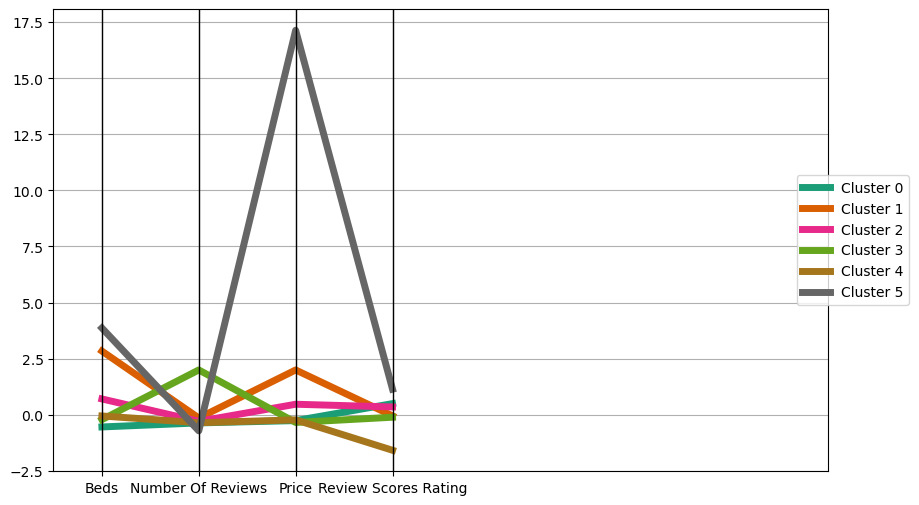

In [438]:
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
fig = plt.figure(figsize=(10, 6))
plt.figure(figsize=(10,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
centroids

C:\Users\SaiKrishna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\SaiKrishna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\SaiKrishna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\SaiKrishna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1

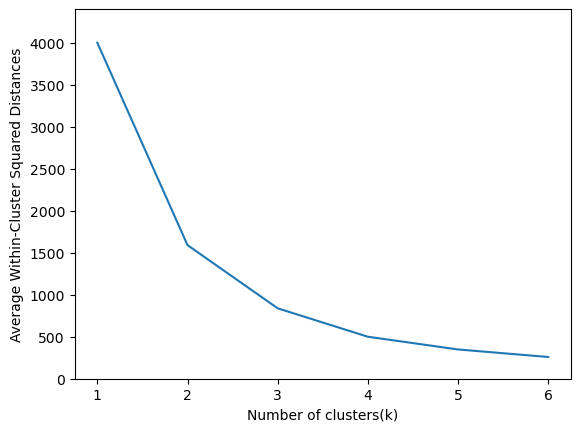

In [440]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_cleaned2_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

In [310]:
log_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
print(log_reg)
# Fit the model with the data
log_reg.fit(X, y)

# The 'log_reg' object now contains the fitted model. You can inspect the coefficients
print("Coefficients:", log_reg.coef_)
print("Intercept:", log_reg.intercept_)

LogisticRegression(C=1e+42, solver='liblinear')
Coefficients: [[ 6.25668504e-03 -3.05889155e-01  3.12987531e-04  4.26568626e-01
   6.43766379e-02 -6.17928296e-01 -6.50584907e-01  2.31618363e+00
  -7.65225721e-01 -5.75782952e-01  2.87962436e+00]]
Intercept: [1.53861569]


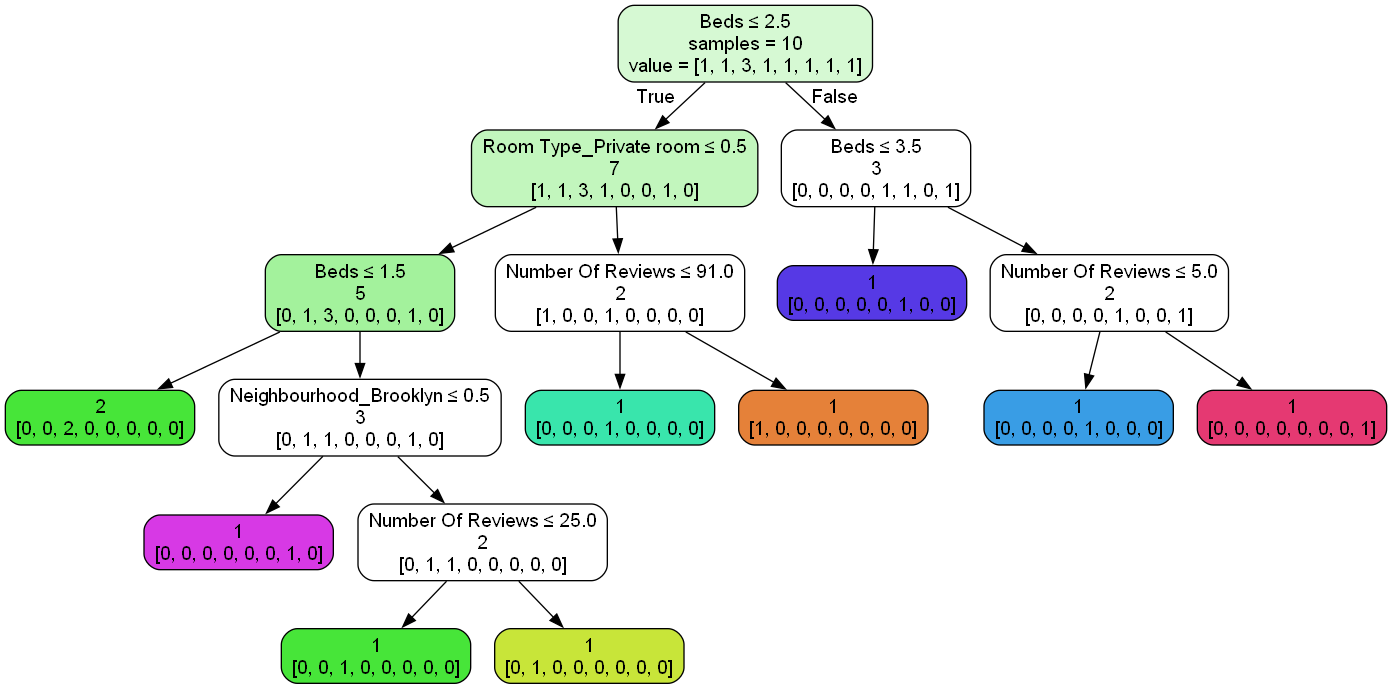

In [322]:
fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(X_train_reg.head(10), y_train_reg.head(10))

plotDecisionTree(fullClassTree, feature_names=X_train_reg.columns)